Run App: "uvicorn main:app --reload"

# Imports

In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm
from typing import Dict
from scipy.signal import resample
import neurokit2 as nk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
import heartpy as hp
import seaborn as sns
import numpy as np
from biosppy.signals import ecg
from scipy.signal import welch

In [165]:
%matplotlib inline
sns.set_theme()

# Import Data

Used Dataset:
- [WESAD: Multimodal Dataset for Wearable Stress and Affect Detection](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/): Exclusively importing the available pickle files from each subject (S2.pkl, S2.pkl, ...) and combining them
- Self-Generated Dataset (ECGPrivate):
    - Device: Bioplux Chest (and Finger) Band
    - Dataframes are modeled following the already implemented pydantic models

In [166]:
# Configs
# wesad respian sampling rate in hz
fs_wesad = 700

In [167]:
def dict_to_dataframe_WESAD(dict):
    df = pd.DataFrame()

    df["ECG"] = dict["signal"]["chest"]["ECG"].flatten()
    df["label"] = dict["label"].flatten()
    df["subject"] = dict["subject"]

    df.reset_index(names="timestamp_idx", inplace=True)

    return df

In [168]:
def combine_pickles_to_df(pattern, wesad_ecg=False):
    """
    Load multiple pickle files that contain similar pandas DataFrames and combine them into a single DataFrame.

    Args:
        pattern (str): A glob pattern that matches the pickle files to load.
        wesad (bool): Whether to convert dictionary objects to DataFrames (used for WESAD dataset).

    Returns:
        A pandas DataFrame that combines the loaded DataFrames.
    """
    dfs = []
    for file_path in tqdm(glob.glob(pattern)):
        with open(file_path, 'rb') as f:
            try:
                df = pd.read_pickle(f)
            except AttributeError:
                raise ValueError(f"Expected a pandas DataFrame, but got {type(df)}")
            if isinstance(df, Dict) and wesad_ecg:
                df = dict_to_dataframe_WESAD(df)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

### WESAD Data

In [169]:
%%time
# load WESAD
df_wesad = combine_pickles_to_df('../data/raw/S15.pkl', wesad_ecg=True)

100%|██████████| 1/1 [00:13<00:00, 13.53s/it]

CPU times: total: 10.3 s
Wall time: 13.7 s


In [170]:
df_wesad

,timestamp_idx,ECG,label,subject
0,0,-0.025543,0,S15
1,1,-0.012955,0,S15
2,2,0.002518,0,S15
3,3,0.008011,0,S15
4,4,0.007141,0,S15
...,...,...,...,...
3676395,3676395,-0.165710,0,S15
3676396,3676396,-0.163330,0,S15
3676397,3676397,-0.138290,0,S15
3676398,3676398,-0.112106,0,S15


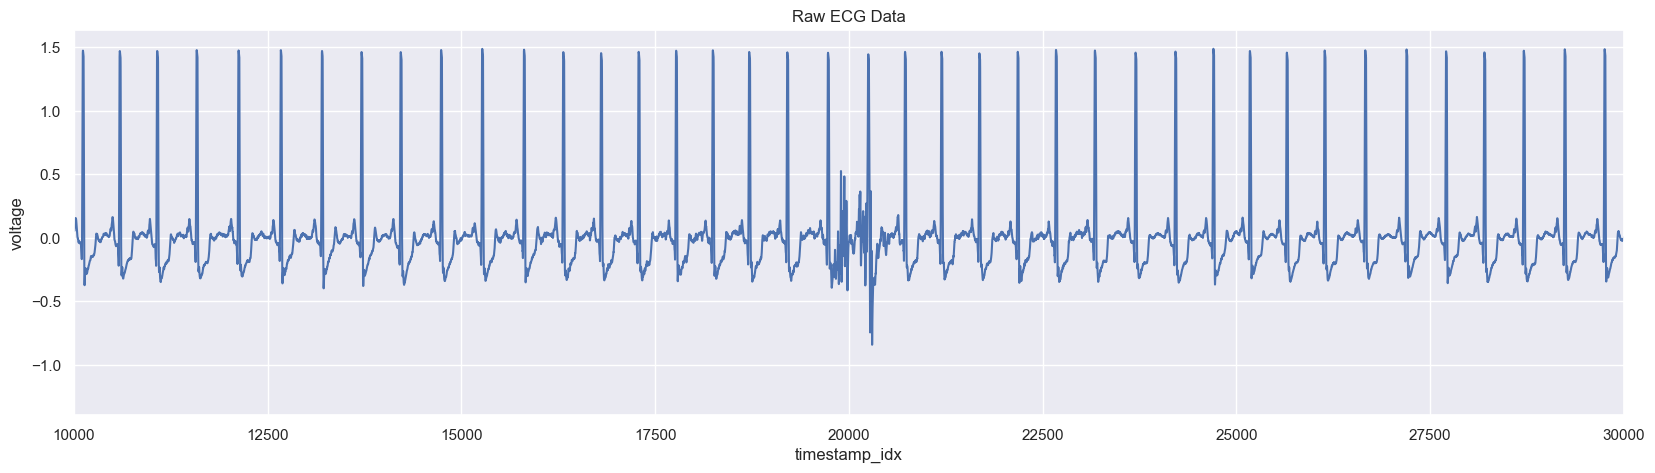

In [171]:
# Plot filtered ECG data
plt.figure(figsize=(20, 5))
plt.plot("timestamp_idx", "ECG", data=df_wesad)
plt.title("Raw ECG Data")
plt.xlabel("timestamp_idx")
plt.ylabel("voltage")
plt.xlim(10000, 30000)
plt.show()

### Self-generated dataset

# Preprocessing

### Normalize

In [178]:
def normalize_data(data):
    # Normalize ECG data to have zero mean and unit variance
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

In [179]:
normalized_ecg = normalize_data(df_wesad["ECG"].values)
normalized_df = df_wesad.copy()
normalized_df["ECG"] = pd.Series(normalized_ecg)

For further usage we are only going to use the standardized data.

In [180]:
df = normalized_df.copy()

### Filtering / Denoising

A band-pass filter allows a range of frequencies to pass while attenuating frequencies outside the range. In most cases, a band-pass filter includes both high-pass and low-pass filters as a part of its design. Therefore, a band-pass filter can attenuate both baseline wander and higher frequency noise in one step.

However, in some cases, using a high-pass filter separately before applying a band-pass filter may be necessary to avoid over-filtering and loss of important ECG signal components. This is especially true if the ECG signal contains low-frequency components of interest, such as the T wave or P wave. For this reason both are used.

Remove basline wander via **highpass filter**

In [181]:
def remove_basline_wander(data, sampling_rate=360, cutoff_freq=0.05):
    # Define filter parameters
    nyquist_freq = 0.5 * sampling_rate  # Nyquist frequency (half of the sampling rate)
       # Cutoff frequency for the high-pass filter (in Hz)
    # Filter order
    filter_order = 3
    # Apply high-pass filter to remove baseline wander
    b, a = butter(filter_order, cutoff_freq/nyquist_freq, 'highpass')
    filtered_data = filtfilt(b, a, data)

    return filtered_data

In [182]:
filtered_ecg = remove_basline_wander(df["ECG"].values, sampling_rate=fs_wesad)
filtered_df = df.copy()
filtered_df["ECG"] = pd.Series(filtered_ecg)

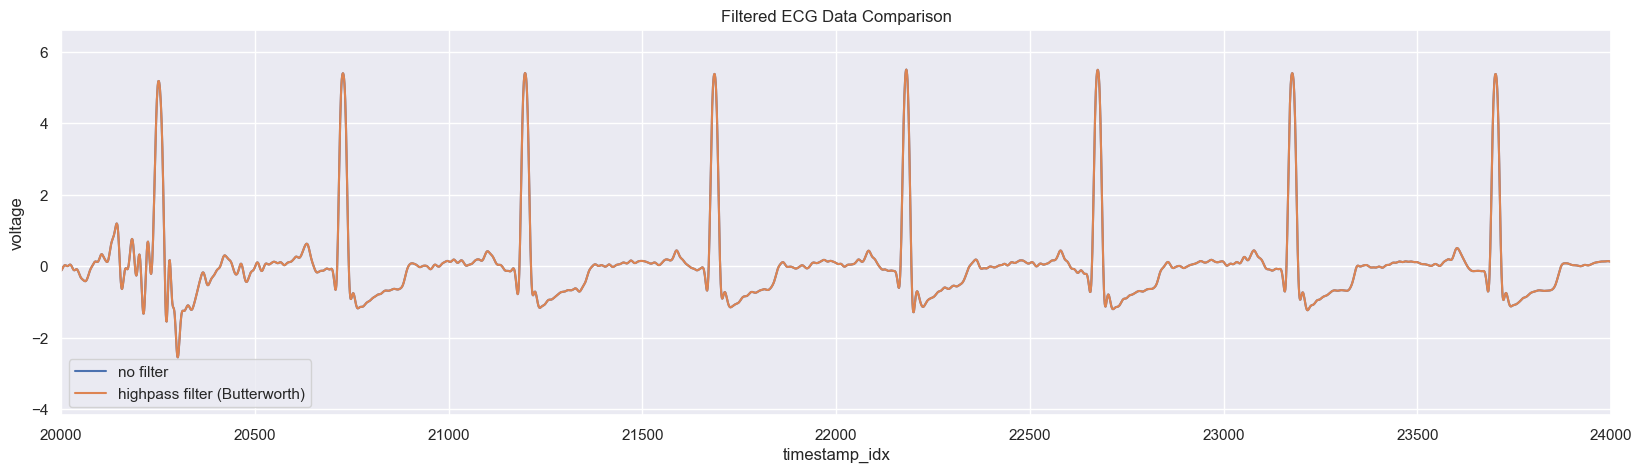

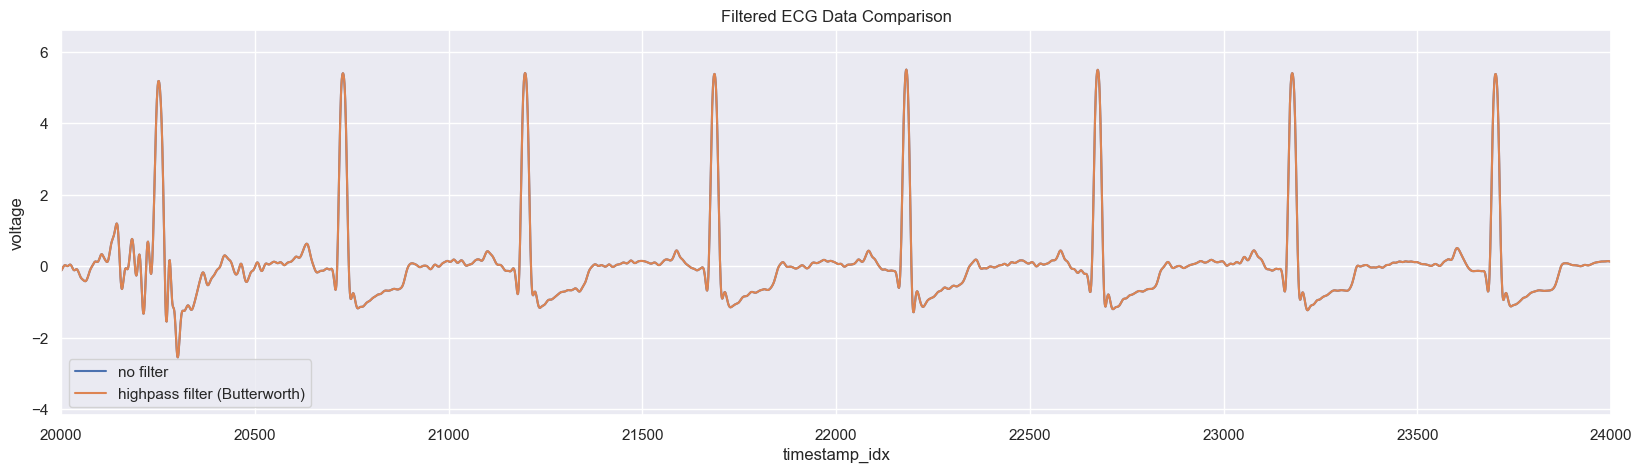

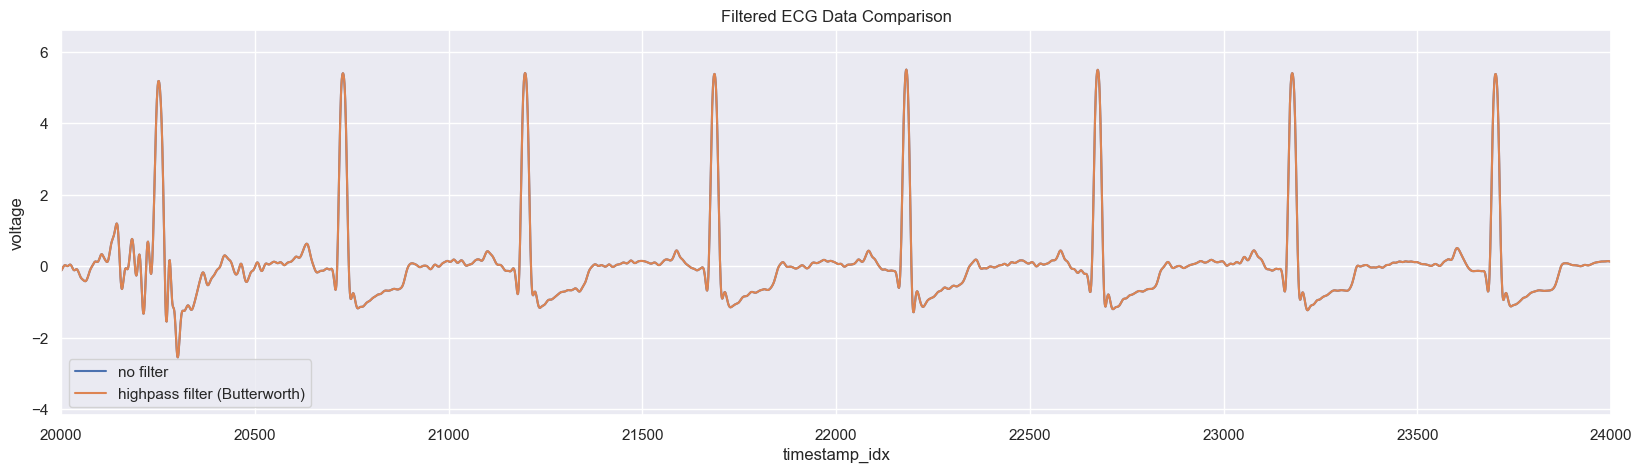

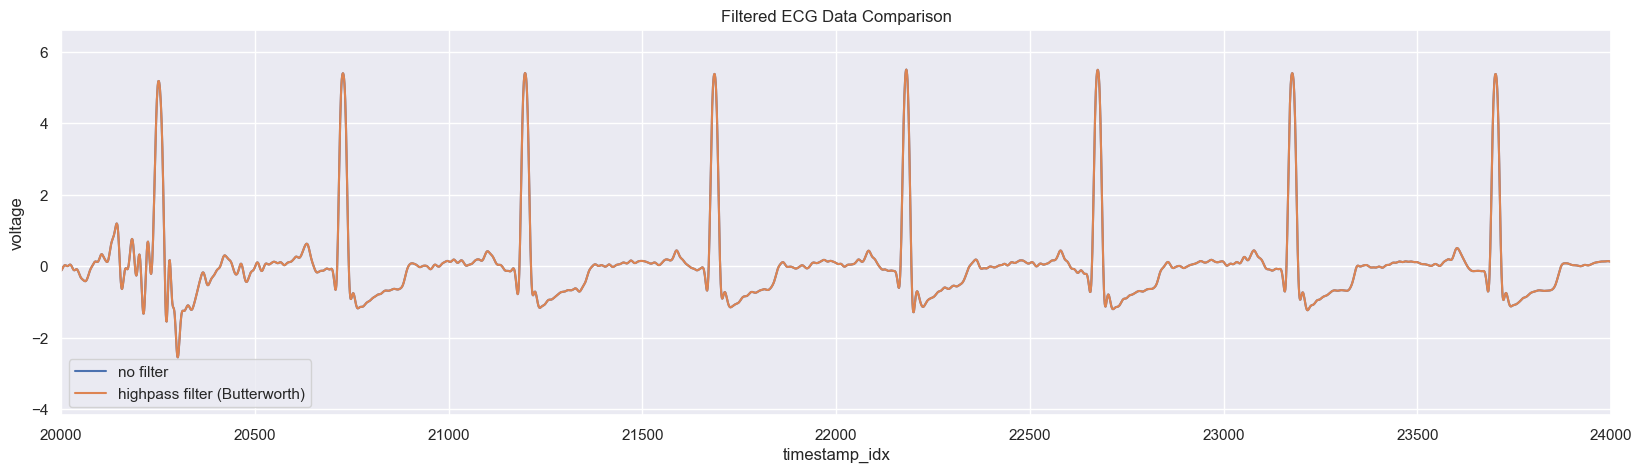

In [186]:
# Plot filtered ECG data
plt.figure(figsize=(20, 5))
plt.plot("timestamp_idx", "ECG", data=df, label="no filter")
plt.plot("timestamp_idx", "ECG", data=filtered_df, label="highpass filter (Butterworth)")
plt.title("Filtered ECG Data Comparison")
plt.xlabel("timestamp_idx")
plt.ylabel("voltage")
plt.xlim(20000, 24000)
plt.legend()
plt.show()

Remove noise via **bandpass filter**

In [187]:
def remove_noise(data, sampling_rate=360, lowcut=0.5, highcut=45):
    # Remove noise from ECG data using bandpass filter
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return pd.Series(filtered_data)

In [188]:
filtered_ecg = remove_noise(df["ECG"].values, sampling_rate=fs_wesad)
filtered_df = df.copy()
filtered_df["ECG"] = pd.Series(filtered_ecg)

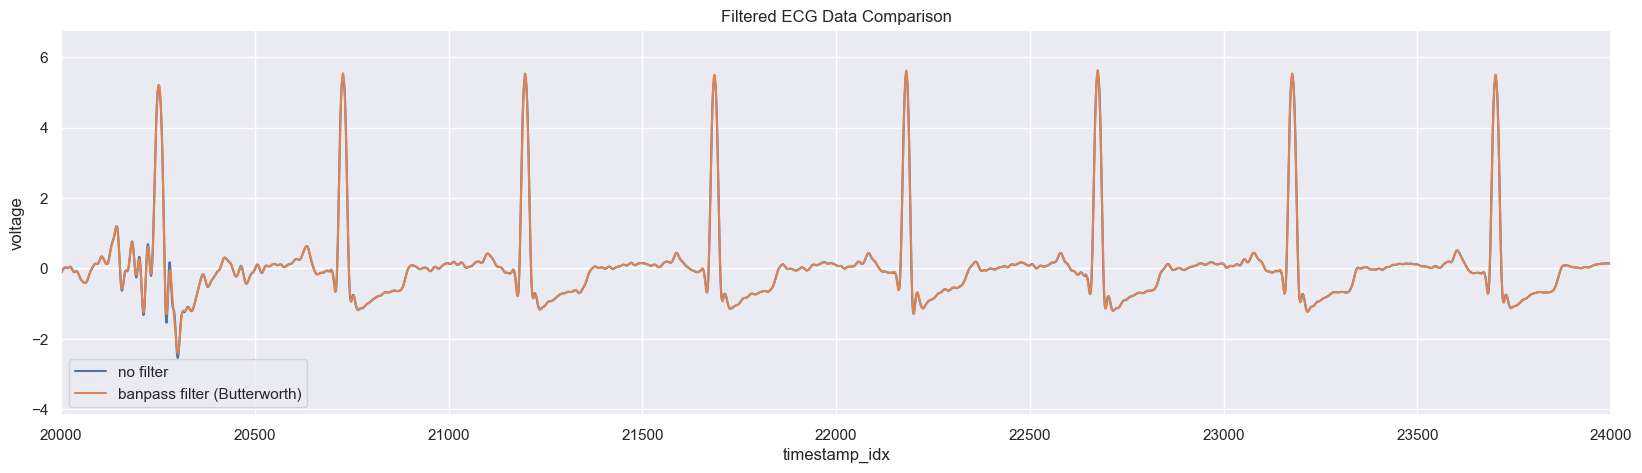

In [189]:
# Plot filtered ECG data
plt.figure(figsize=(20, 5))
plt.plot("timestamp_idx", "ECG", data=df, label="no filter")
plt.plot("timestamp_idx", "ECG", data=filtered_df, label="banpass filter (Butterworth)")
plt.title("Filtered ECG Data Comparison")
plt.xlabel("timestamp_idx")
plt.ylabel("voltage")
plt.xlim(20000, 24000)
plt.legend()
plt.show()

### Sample Rate

 Change Sampling Rate

In [190]:
def resample_data(data, original_sampling_rate, new_sampling_rate=360):
    # Resample ECG data to a new sampling rate
    resampled_data = resample(data, int(len(data) * new_sampling_rate / original_sampling_rate))
    return resampled_data

In [191]:
resampled_ecg = resample_data(df["ECG"], original_sampling_rate=fs_wesad)
resampled_df = df.copy()
resampled_df["ECG"] = pd.Series(resampled_ecg)

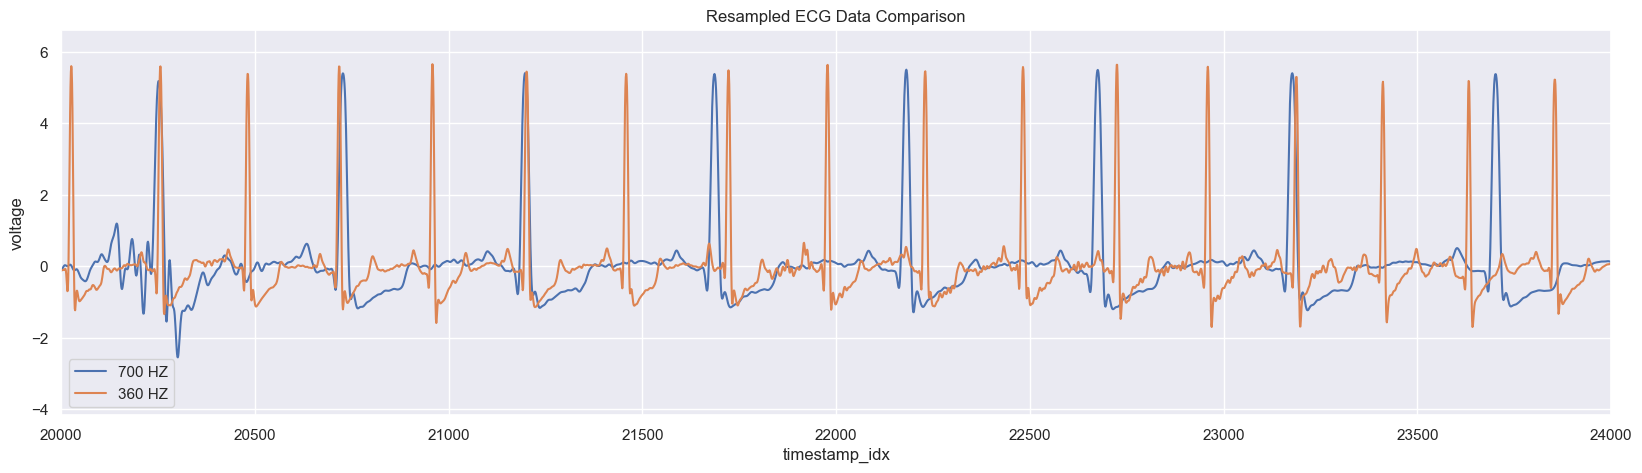

In [192]:
# Plot resampled ECG data
plt.figure(figsize=(20, 5))
plt.plot("timestamp_idx", "ECG", data=df, label=f"{fs_wesad} HZ")
plt.plot("timestamp_idx", "ECG", data=resampled_df, label="360 HZ")
plt.title("Resampled ECG Data Comparison")
plt.xlabel("timestamp_idx")
plt.ylabel("voltage")
plt.xlim(20000, 24000)
plt.legend()
plt.show()

Process and clean via **pantompkins**?

In [193]:
# Process the ecg signal
#cleaned = nk.ecg_clean(df['ECG'], sampling_rate=fs, method="pantompkins1985")
#signals, info = nk.ecg_peaks(cleaned, sampling_rate=fs, method="pantompkins1985", correct_artifacts=True)

# Plot the data if of interest
#nk.events_plot(info["ECG_R_Peaks"], cleaned)

**Wavelet**?

### Preprocessing Pipeline

In [194]:
def preprocess_data(data, sampling_rate, new_sampling_rate=360):
    # Remove basline wander using highpass filter
    filtered_data = remove_basline_wander(data=data, sampling_rate=sampling_rate)
    # Remove noise from ECG data using bandpass filter
    filtered_data = remove_noise(data=filtered_data, sampling_rate=sampling_rate)
    # Resample ECG data to a new sampling rate
    resampled_data = resample_data(data=filtered_data, new_sampling_rate=new_sampling_rate, original_sampling_rate=sampling_rate)
    # Normalize ECG data to have zero mean and unit variance
    normalized_data = normalize_data(resampled_data)
    return normalized_data

In [199]:
%%time
preprocessed_ecg = preprocess_data(df_wesad["ECG"].values, sampling_rate=fs_wesad)
preprocessed_df = df_wesad.copy()
preprocessed_df["ECG"] = pd.Series(preprocessed_ecg)

CPU times: total: 1.23 s
Wall time: 1.44 s


# Features

Sources: "Heart rate variability: standards of measurement, physiological interpretation and clinical use" by the Task Force of the European Society of Cardiology and the North American Society of Pacing and Electrophysiology (1996)

* **Time Domain Features**:
    * **Mean RR interval**: the average length of time between successive R peaks in the ECG signal. This feature provides a general estimate of the heart rate.
    * **SDNN (standard deviation of normal-to-normal intervals)**: the standard deviation of the intervals between successive R peaks in the ECG signal, excluding any abnormal beats or ectopic beats. This feature provides an estimate of the overall variability of the heart rate.
    * **RMSSD (root mean square of successive differences)**: the square root of the mean of the squared differences between successive normal-to-normal intervals. This feature provides an estimate of the short-term variability of the heart rate.
    * **NN50**: the number of pairs of successive normal-to-normal intervals that differ by more than 50 ms. This feature provides an estimate of the parasympathetic nervous system activity.
    * **pNN50**: the percentage of pairs of successive normal-to-normal intervals that differ by more than 50 ms. This feature provides a normalized measure of the parasympathetic nervous system activity.
* **Frequency Domain Feature**:
    * **LF (low-frequency) band power**: the power in the ECG signal in the frequency band between 0.04 Hz and 0.15 Hz. This feature provides an estimate of the sympathetic and parasympathetic nervous system activity.
    * **HF (high-frequency) band power**: the power in the ECG signal in the frequency band between 0.15 Hz and 0.4 Hz. This feature provides an estimate of the parasympathetic nervous system activity.
    * **LF/HF ratio**: the ratio of LF power to HF power. This feature provides an estimate of the balance between sympathetic and parasympathetic nervous system activity.
* nonlinear features from RR intervals?

In [216]:
def hrv_features(data, fs):
    # Compute RR intervals from ECG data
    rpeaks, = ecg.hamilton_segmenter(signal=data, sampling_rate=fs)
    rr_intervals = np.diff(rpeaks) / fs

    # Compute time domain features from RR intervals
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = nn50 / len(rr_intervals)

    # Compute frequency domain features from RR intervals
    freq, power = welch(rr_intervals, fs=fs, nperseg=256, noverlap=128, nfft=512)
    lf_band = np.sum(power[(freq >= 0.04) & (freq <= 0.15)])
    hf_band = np.sum(power[(freq >= 0.15) & (freq <= 0.4)])
    lf_hf_ratio = lf_band / hf_band

    # Return HRV features as a dictionary
    features = {
        'mean_rr': mean_rr,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'nn50': nn50,
        'pnn50': pnn50,
        'lf_band': lf_band,
        'hf_band': hf_band,
        'lf_hf_ratio': lf_hf_ratio,
    }
    return features

In [217]:
%%time
# Compute HRV features
hrv = hrv_features(preprocessed_ecg, fs_wesad)

CPU times: total: 4.42 s
Wall time: 4.72 s


In [218]:
# Convert from sec (s) to millisec (ms)(sx1000 -> ms)

# Print HRV features
print(f"HRV features in seconds: {hrv}")

{'mean_rr': 0.3888295793479378, 'sdnn': 0.04855301577461295, 'rmssd': 0.023442916275948127, 'nn50': 210, 'pnn50': 0.03023758099352052, 'lf_band': 0.0, 'hf_band': 0.0, 'lf_hf_ratio': nan}
